# Making a mock observation from the EAGLE simulations

This script is an example script to lay out the individual steps of making mock observations.

The steps are as follows:

1. Load the EAGLE simulated data.  Specify the distance at which we want to observe the cosmic web i.e. redshift of central wavelength of filter and the resolution that the data should be binned to.  The minimum resolution at 50Mpc away is about 14".
2. Cut out a chunk of the simulated data that corresponds to the Dragonfly FOV.  (switched with step 3 because takes too long for the whole simulation)
3. Add the noise to the simulated data to mimic observational noises (includes sky background noise, read out noise, dark current noise, and shot noise).  This depends on the exposure time of the mock observation.
4. Plot the data to check and see what it looks like.

Ta da!

In [1]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u
from astropy.io import fits

import os
#import get_halpha_SB

%matplotlib inline

%run 'load_data.ipynb'
%run 'add_noise.ipynb'
%run 'extract_FOV.ipynb'

In [14]:
machine='chinook'

def get_noisydata(resolution,distance,slicewidth,exptime,CMOS=False,ROnoise=None,x_center=47.5,y_center=12.,plotnoise=True):
    print "****** Working on mock observation for distance %s ******"%distance
    print 'loading the data...'
    data_tuple = loaddata(machine=machine,resolution=resolution,distance=distance,slicewidth=slicewidth)
    print 'extracting the FOV...'
    data_FOV, xystarts, size = extractFOV(data_tuple,resolution,distance,x_center=x_center,y_center=y_center)
    filterwidth = 3.
    if int(slicewidth) == 20:
        filterwidth=3.
    elif int(slicewidth) == 5:
        filterwidth=1.
    else:
        print "ERROR: not sure what filter width to use..."
    print 'adding noise to the data...'
    noiseadded_signal,B_sky_array,R_array,D_array = addnoise(data_FOV,resolution,exptime=exptime,filterwidth=filterwidth,\
                                                             CMOS=CMOS,R=ROnoise,debugging=True)
    
    print 'saving the noise-added data...'
    if CMOS:
        cams = 'newcam'
    else:
        cams = 'oldcam'
    if ROnoise:
        cams = cams+'_ROnoise%s'%ROnoise

    sim_fitsname = 'noisy_fov_%shr_%s_%sdist_%sarcsec_%sslwd_xycenter_%s_%s_RAWSIM.fits' \
            % (round(exptime/3600.),cams,distance,resolution,slicewidth,x_center,y_center)
    fname = 'noisy_fov_%shr_%s_%sdist_%sarcsec_%sslwd_xycenter_%s_%s.npz' \
            % (round(exptime/3600.),cams,distance,resolution,slicewidth,x_center,y_center)
    fitsname = 'noisy_fov_%shr_%s_%sdist_%sarcsec_%sslwd_xycenter_%s_%s.fits' \
            % (round(exptime/3600.),cams,distance,resolution,slicewidth,x_center,y_center)
    R_fname = 'noisy_fov_%shr_%s_%sdist_%sarcsec_%sslwd_xycenter_%s_%s_RARRAY.npz' \
            % (round(exptime/3600.),cams,distance,resolution,slicewidth,x_center,y_center)
    B_sky_fname = 'noisy_fov_%shr_%s_%sdist_%sarcsec_%sslwd_xycenter_%s_%s_BSKYARRAY.npz' \
            % (round(exptime/3600.),cams,distance,resolution,slicewidth,x_center,y_center)
    D_fname = 'noisy_fov_%shr_%s_%sdist_%sarcsec_%sslwd_xycenter_%s_%s_DARRAY.npz' \
            % (round(exptime/3600.),cams,distance,resolution,slicewidth,x_center,y_center)
    noiseplot = 'noisy_fov_%shr_%s_%sdist_%sarcsec_%sslwd_xycenter_%s_%s.png' \
            % (round(exptime/3600.),cams,distance,resolution,slicewidth,x_center,y_center)
        
    print "Saving mock observation as %s"%fname
    np.savez(fname,noiseadded_signal)
    hdu = fits.PrimaryHDU(data=noiseadded_signal)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(fitsname,clobber=True)
    hdulist.close()

    print "xystarts are:"
    print xystarts
    print "size is:"
    print size
    print "Saving the input simulation as %s"%sim_fitsname
    hdu = fits.PrimaryHDU(data=data_FOV)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(sim_fitsname,clobber=True)
    hdulist.close()
    print "Saving readout noise array as %s"%R_fname
    np.savez(R_fname,R_array)
    print "Saving the sky background array as %s"%B_sky_fname
    np.savez(B_sky_fname,B_sky_array)
    print "Saving the sky background array as %s"%D_fname
    np.savez(D_fname,D_array)
    
    if plotnoise:
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.hist(np.ravel(np.log10(B_sky_array[B_sky_array>0])),edgecolor='black', alpha = 1.,bins=50,label='sky noise')
        ax1.hist(np.ravel(np.log10(R_array[R_array>0])),edgecolor='black', alpha = 0.8,bins=50,label='readout noise')
        ax1.hist(np.ravel(np.log10(D_array[D_array>0])),edgecolor='black', alpha = 0.5,bins=50,label='dark current noise')
#       ax1.hist(np.ravel(np.log10(detsignal)),edgecolor='black', alpha = 0.3,bins=50,label = 'detected signal')
        ax1.set_xlabel('log ( photons / binned pixel)')
        ax1.set_ylabel('number of pixels')
        ax1.legend()
    
        ax2.hist(np.ravel(B_sky_array),edgecolor='black', alpha = 1.,bins=50,label='sky noise'+r', $\sigma_B$ = %.1f'%(np.std(B_sky_array)) )
        ax2.hist(np.ravel(R_array),edgecolor='black', alpha = 0.8,bins=50,label='readout noise'+r', $\sigma_R$ = %.1f'%(np.std(R_array)) )
        ax2.hist(np.ravel(D_array),edgecolor='black', alpha = 0.5,bins=50,label='dark current noise'+r', $\sigma_D$ = %.1f'%(np.std(D_array)) )
#       ax1.hist(np.ravel(np.log10(detsignal)),edgecolor='black', alpha = 0.3,bins=50,label = 'detected signal')
        ax2.set_xlabel('( photons / binned pixel)')
        ax2.set_ylabel('number of pixels')
        plt.legend(loc='upper left')
        
        plt.savefig(noiseplot)

    
    print "****** Done mock observation for distance %s ******"%distance
    print ""
    return data_FOV, xystarts, size, noiseadded_signal, B_sky_array, R_array, D_array

In [35]:
resolution = 100.; slicewidth = 20; exptime = 1000.*60.*60.; CMOS = False; ROnoise= None; x_center = 50.5; y_center = 13.5

distance = '500Mpc'
data_FOV_500, xystarts_500, size_500, noiseadded_signal_500, B_sky_array_500, R_array_500,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '200Mpc'
data_FOV_200, xystarts_200, size_200, noiseadded_signal_200, B_sky_array_200, R_array_200,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '100Mpc'
data_FOV_100, xystarts_100, size_100, noiseadded_signal_100, B_sky_array_100, R_array_100,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '50Mpc'
data_FOV_50, xystarts_50, size_50, noiseadded_signal_50, B_sky_array_50, R_array_50,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

****** Working on mock observation for distance 500Mpc ******
loading the data...
Loading data of slicewidth 20 (after rounding), number of slices is 4
data_500Mpc_100arcsec_20slwd.npz exists, loading now...
extracting the FOV...
adding noise to the data...
******* Adding noise to the input data to simulate a mock observation by the 48.0 lens Dragonfly Telescope *******
DEBUGGING: the binpix_size (resolution) is 100.0
DEBUGGING: the pixel size (inherent) is 2.8
VERBOSE: Using old cameras... (QE = 0.48, R = 10.)
DEBUGGING: R is : 10.0
DEBUGGING: the number of pixels per bin is 1296.0
DEBUGGING: raise the data by 10** since was logged data before...
DEBUGGING: the total object signal [electrons] detected ranges from: 1.38442 to 1.74487e+08
The width of the filter that the data was taken with is 3.0 nm. 
DEBUGGING: Sky background in filter width of 3.0 nm is calculated already: 1.473626.
Adding sky background noise and shot noise...
DEBUGGING: the background in the bandwidth is: 1.473626 

In [4]:
resolution = 100.; slicewidth = 20; exptime = 1000.*60.*60.; CMOS = False; ROnoise= None; x_center = 30.5; y_center = 67.5

distance = '500Mpc'
data_FOV_500, xystarts_500, size_500, noiseadded_signal_500, B_sky_array_500, R_array_500,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '200Mpc'
data_FOV_200, xystarts_200, size_200, noiseadded_signal_200, B_sky_array_200, R_array_200,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '100Mpc'
data_FOV_100, xystarts_100, size_100, noiseadded_signal_100, B_sky_array_100, R_array_100,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '50Mpc'
data_FOV_50, xystarts_50, size_50, noiseadded_signal_50, B_sky_array_50, R_array_50,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

****** Working on mock observation for distance 500Mpc ******
loading the data...
Loading data of slicewidth 20 (after rounding), number of slices is 4
data_500Mpc_14arcsec_20slwd.npz exists, loading now...
extracting the FOV...
adding noise to the data...
******* Adding noise to the input data to simulate a mock observation by the 48.0 lens Dragonfly Telescope *******
DEBUGGING: the binpix_size (resolution) is 14.0
DEBUGGING: the pixel size (inherent) is 2.8
VERBOSE: Using old cameras... (QE = 0.48, R = 10.)
DEBUGGING: R is : 10.0
DEBUGGING: the number of pixels per bin is 25.0
DEBUGGING: raise the data by 10** since was logged data before...
DEBUGGING: the total object signal [electrons] detected ranges from: 0.0136454 to 1.15728e+08
The width of the filter that the data was taken with is 3.0 nm. 
DEBUGGING: Sky background in filter width of 3.0 nm is calculated already: 1.473626.
Adding sky background noise and shot noise...
DEBUGGING: the background in the bandwidth is: 1.473626 ph

In [33]:
resolution = 14.; slicewidth = 5; exptime = 1000.*60.*60.; CMOS = True; ROnoise= None; x_center = 50.5; y_center = 13.5

distance = '500Mpc'
data_FOV_500, xystarts_500, size_500, noiseadded_signal_500, B_sky_array_500, R_array_500,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '200Mpc'
data_FOV_200, xystarts_200, size_200, noiseadded_signal_200, B_sky_array_200, R_array_200,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '100Mpc'
data_FOV_100, xystarts_100, size_100, noiseadded_signal_100, B_sky_array_100, R_array_100,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '50Mpc'
data_FOV_50, xystarts_50, size_50, noiseadded_signal_50, B_sky_array_50, R_array_50,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

****** Working on mock observation for distance 500Mpc ******
loading the data...
data_500Mpc_14arcsec.npz exists, loading now...
extracting the FOV...
adding noise to the data...
******* Adding noise to the input data to simulate a mock observation by the 48.0 lens Dragonfly Telescope *******
DEBUGGING: the binpix_size (resolution) is 14.0
DEBUGGING: the pixel size (inherent) is 2.8
VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)
DEBUGGING: R is : 2.0
DEBUGGING: the number of pixels per bin is 25.0
DEBUGGING: raise the data by 10** since was logged data before...
DEBUGGING: the total object signal [electrons] detected ranges from: 8.47099e-05 to 1.54142e+08
The width of the filter that the data was taken with is 1.0 nm. 
DEBUGGING: Sky background in filter width of 1.0 nm is calculated already: 0.560633.
Adding sky background noise and shot noise...
DEBUGGING: the background in the bandwidth is: 0.560633 photon/s/arcsec^2/m^2
DEBUGGING: the background signal, B_sky, is: 2.01611

In [15]:
resolution = 14.; slicewidth = 5; exptime = 1000.*60.*60.; CMOS = False; ROnoise= None; x_center = 30.5; y_center = 67.5

distance = '500Mpc'
data_FOV_500, xystarts_500, size_500, noiseadded_signal_500, B_sky_array_500, R_array_500,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '200Mpc'
data_FOV_200, xystarts_200, size_200, noiseadded_signal_200, B_sky_array_200, R_array_200,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '100Mpc'
data_FOV_100, xystarts_100, size_100, noiseadded_signal_100, B_sky_array_100, R_array_100,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '50Mpc'
data_FOV_50, xystarts_50, size_50, noiseadded_signal_50, B_sky_array_50, R_array_50,D_fname = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

****** Working on mock observation for distance 500Mpc ******
loading the data...
data_500Mpc_14arcsec.npz exists, loading now...
extracting the FOV...
adding noise to the data...
******* Adding noise to the input data to simulate a mock observation by the 48.0 lens Dragonfly Telescope *******
DEBUGGING: the binpix_size (resolution) is 14.0
DEBUGGING: the pixel size (inherent) is 2.8
VERBOSE: Using old cameras... (QE = 0.48, R = 10.)
DEBUGGING: R is : 10.0
DEBUGGING: the number of pixels per bin is 25.0
DEBUGGING: raise the data by 10** since was logged data before...
DEBUGGING: the total object signal [electrons] detected ranges from: 0.000181274 to 1.1174e+08
The width of the filter that the data was taken with is 1.0 nm. 
DEBUGGING: Sky background in filter width of 1.0 nm is calculated already: 0.560633.
Adding sky background noise and shot noise...
DEBUGGING: the background in the bandwidth is: 0.560633 photon/s/arcsec^2/m^2
DEBUGGING: the background signal, B_sky, is: 1.382477516

# Data to give to Pieter and Bob:

****** Working on mock observation for distance 500Mpc ******
loading the data...
Loading data of slicewidth 20 (after rounding), number of slices is 4
./intermediatedata/data_500Mpc_14arcsec_20slwd.npz does not exist, making it now...
Data exists, loading ./intermediatedata/emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_20slice_zcen12.5_total.npz now...
Reducing the resolution to desired distance/resolution...
Will reduce resolution by a factor of 11.0.
Before reducing resolution, the original data was trimmed to size 31999.0.
DEBUGGING: data_tuple is: 
(array([[-2.6225338 , -2.65648484, -2.70314932, ..., -2.51786304,
        -2.52013803, -2.56654429],
       [-2.59379625, -2.61996222, -2.67681098, ..., -2.50686026,
        -2.50434613, -2.54327202],
       [-2.55740666, -2.5763092 , -2.63905406, ..., -2.51177907,
        -2.50627613, -2.53119588],
       ..., 
       [-2.70764995, -2.73565054, -2.75578046, ..., -2.62690639,
        -2.64176464, -2.6825223 ],
       [-2.714120

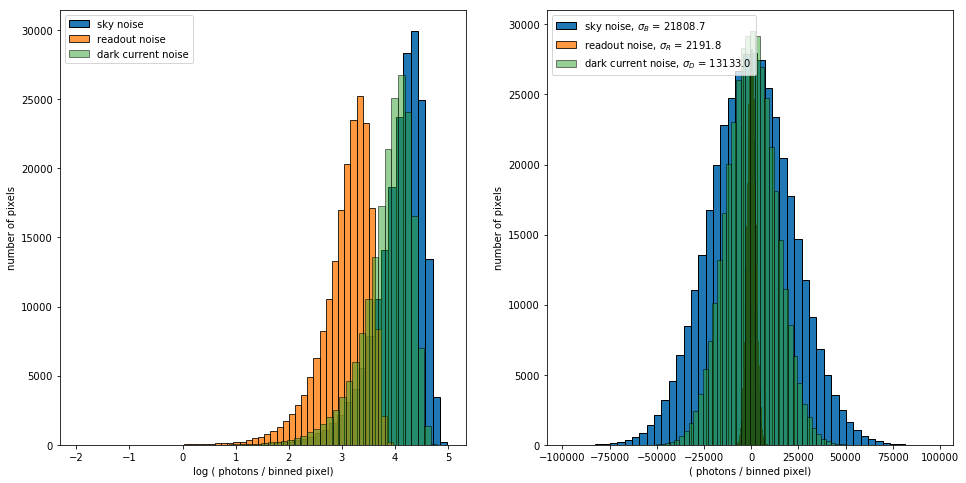

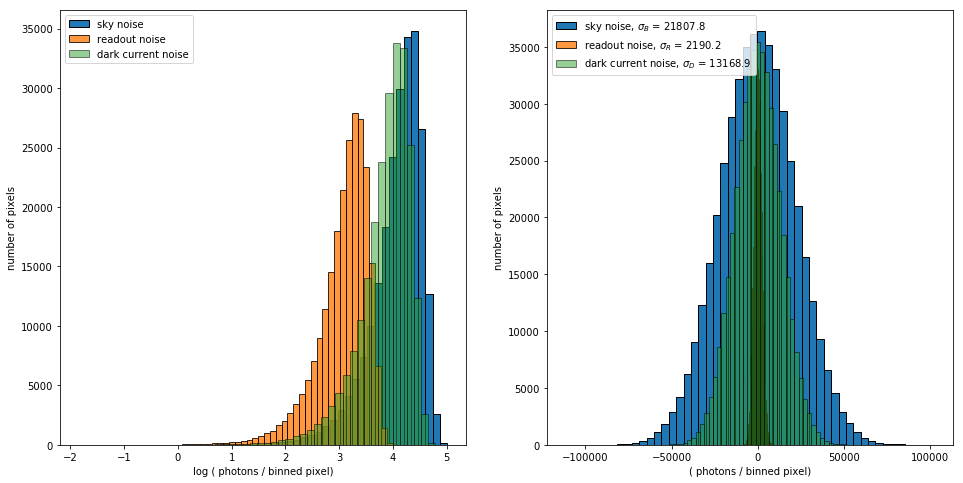

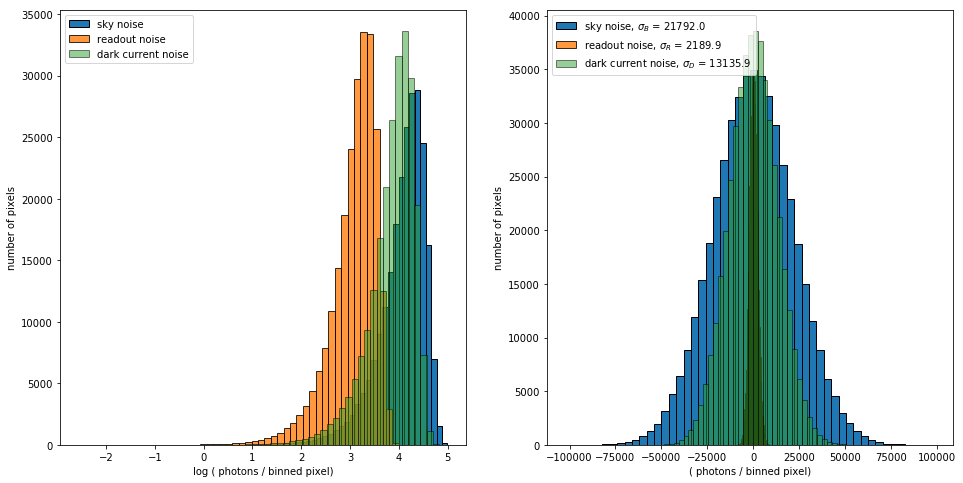

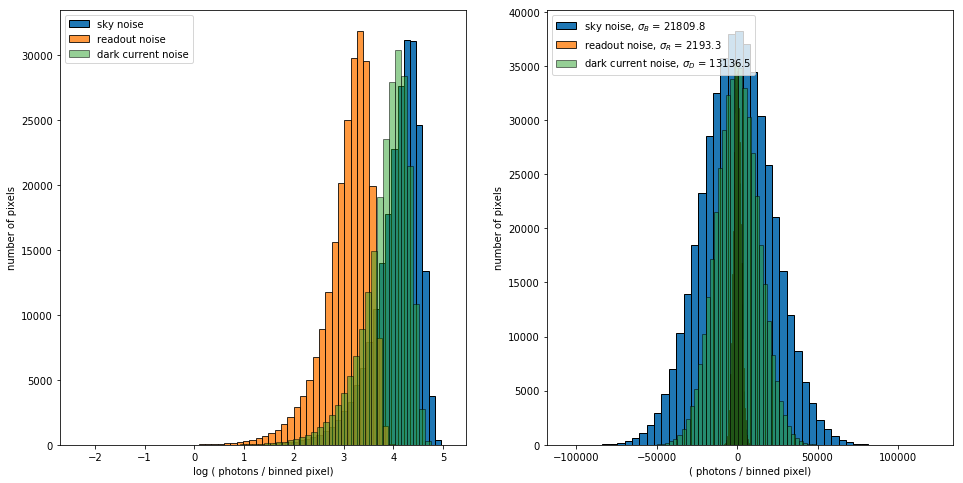

In [15]:
resolution = 14.; slicewidth = 20; exptime = 1000.*60.*60.; CMOS = True; ROnoise= None; x_center = 50.5; y_center = 13.5

distance = '500Mpc'
data_FOV_500, xystarts_500, size_500, noiseadded_signal_500, B_sky_array_500, R_array_500,D_array500 = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '200Mpc'
data_FOV_200, xystarts_200, size_200, noiseadded_signal_200, B_sky_array_200, R_array_200,D_array200 = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '100Mpc'
data_FOV_100, xystarts_100, size_100, noiseadded_signal_100, B_sky_array_100, R_array_100,D_array100 = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

distance = '50Mpc'
data_FOV_50, xystarts_50, size_50, noiseadded_signal_50, B_sky_array_50, R_array_50,D_array50 = get_noisydata(resolution,distance,slicewidth,exptime,CMOS=CMOS,ROnoise=ROnoise,x_center=x_center,y_center=y_center)

Make some plots to show the RO noise, SB noise and DC noise. --- These are now part of the main script to run the mock observations (at the top of this script).  They can be toggled on/off.

(767, 511) (767, 511) (767, 511) (767, 511)


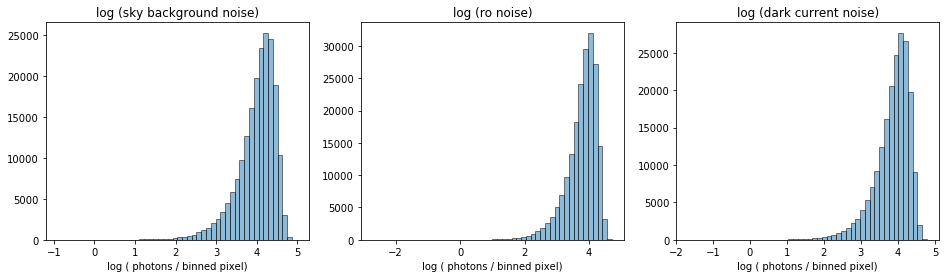

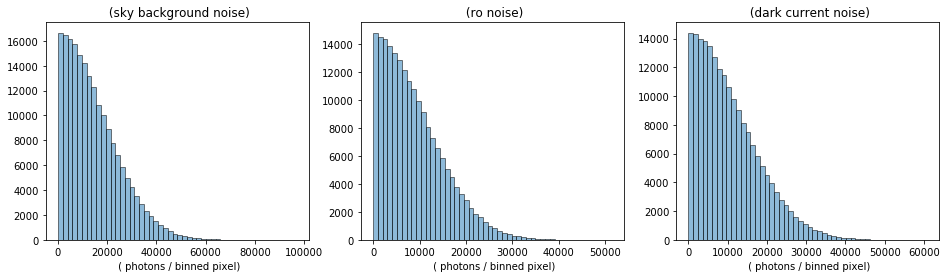

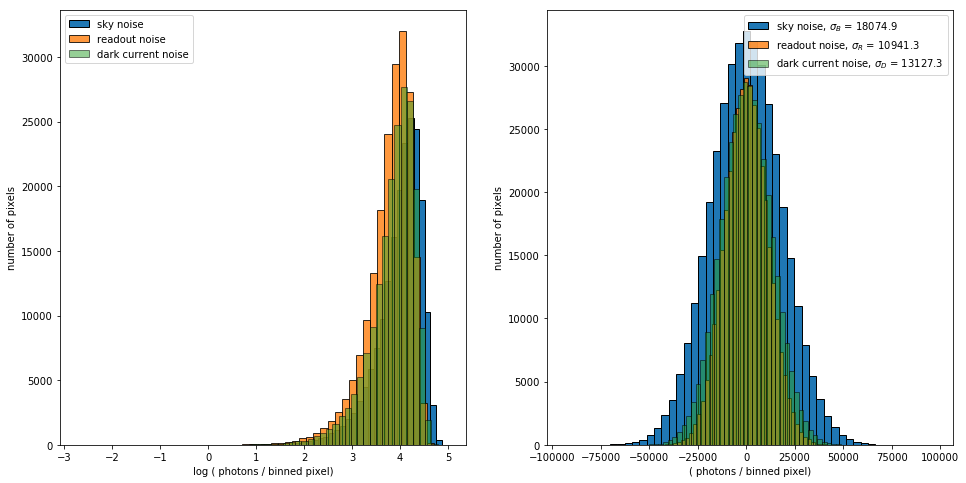

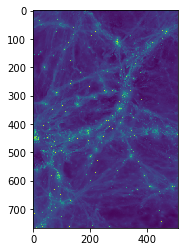

In [39]:
print data_FOV_500.shape, B_sky_array_500.shape, R_array_500.shape, D_array500.shape

def plotchecks(B_sky_array,R_array,D_array):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 4))
    ax1.hist(np.ravel(np.log10(B_sky_array[B_sky_array>0])),edgecolor='black', alpha = 0.5,bins=50)      
    ax1.set_title('log (sky background noise)')
    ax1.set_xlabel('log ( photons / binned pixel)')
    ax2.hist(np.ravel(np.log10(R_array[R_array>0])),edgecolor='black', alpha = 0.5,bins=50)
    ax2.set_title('log (ro noise)')
    ax2.set_xlabel('log ( photons / binned pixel)')
    ax3.hist(np.ravel(np.log10(D_array[D_array>0])),edgecolor='black', alpha = 0.5,bins=50)
    ax3.set_title('log (dark current noise)')
    ax3.set_xlabel('log ( photons / binned pixel)')
  
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 4))
    ax1.hist(np.ravel((B_sky_array[B_sky_array>0])),edgecolor='black', alpha = 0.5,bins=50)
    ax1.set_title(' (sky background noise)')
    ax1.set_xlabel(' ( photons / binned pixel)')
    ax2.hist(np.ravel((R_array[R_array>0])),edgecolor='black', alpha = 0.5,bins=50)
    ax2.set_title(' (ro noise)')
    ax2.set_xlabel(' ( photons / binned pixel)')
    ax3.hist(np.ravel((D_array[D_array>0])),edgecolor='black', alpha = 0.5,bins=50)
    ax3.set_title(' (dark current noise)')
    ax3.set_xlabel(' ( photons / binned pixel)')
    
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8))
    ax1.hist(np.ravel(np.log10(B_sky_array[B_sky_array>0])),edgecolor='black', alpha = 1.,bins=50,label='sky noise')
    ax1.hist(np.ravel(np.log10(R_array[R_array>0])),edgecolor='black', alpha = 0.8,bins=50,label='readout noise')
    ax1.hist(np.ravel(np.log10(D_array[D_array>0])),edgecolor='black', alpha = 0.5,bins=50,label='dark current noise')
#       ax1.hist(np.ravel(np.log10(detsignal)),edgecolor='black', alpha = 0.3,bins=50,label = 'detected signal')
    ax1.set_xlabel('log ( photons / binned pixel)')
    ax1.set_ylabel('number of pixels')
    ax1.legend()
    
    ax2.hist(np.ravel(B_sky_array),edgecolor='black', alpha = 1.,bins=50,label='sky noise'+r', $\sigma_B$ = %.1f'%(np.std(B_sky_array)) )
    ax2.hist(np.ravel(R_array),edgecolor='black', alpha = 0.8,bins=50,label='readout noise'+r', $\sigma_R$ = %.1f'%(np.std(R_array)) )
    ax2.hist(np.ravel(D_array),edgecolor='black', alpha = 0.5,bins=50,label='dark current noise'+r', $\sigma_D$ = %.1f'%(np.std(D_array)) )
#       ax1.hist(np.ravel(np.log10(detsignal)),edgecolor='black', alpha = 0.3,bins=50,label = 'detected signal')
    ax2.set_xlabel('( photons / binned pixel)')
    ax2.set_ylabel('number of pixels')
    plt.legend()

    return

plotchecks(B_sky_array_500, R_array_500, D_array500)
fig, (ax) = plt.subplots(1, 1, figsize=(9, 4))
img = ax.imshow(data_FOV_500)
plt.show()

In [28]:
#fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
#get_halpha_SB.makemap(noiseadded_signal_500,size_500,ax1,xystarts = xystarts_500)
#get_halpha_SB.makemap(noiseadded_signal_200,size_200,ax2,xystarts = xystarts_200)
#plt.tight_layout()

In [32]:
fname = 'data_50Mpc_14arcsec.npz'
data = (np.load(fname)['arr_0'])